In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

In [2]:
# with open("resources/objects/private/nisse_15k.json") as f:
#     data = json.load(f)
with open("resources/objects/private/nisse_full.json") as f:
    data = json.load(f)

In [3]:
means = []
rots = []
scales = []
for k, v in data.items():
    means.append(v["xyz"])
    rots.append(np.array(v["rot"]))
    scales.append(v["scale"])

means = np.stack(means)
rots = np.stack(rots)
scales = np.clip(np.stack(scales), a_min=1e-2, a_max=1e14)

In [4]:
means.shape

(157291, 3)

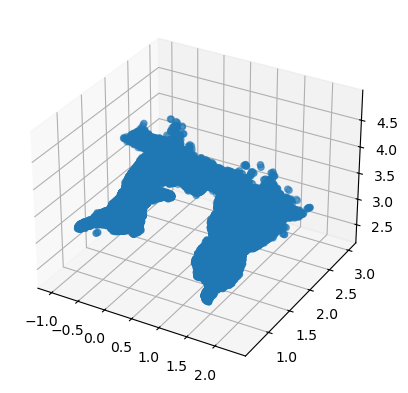

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*means.T)

In [6]:
aabb = [means.min(0), means.max(0)]
boxsize = aabb[1] - aabb[0]
aabb_root = [aabb[0] - boxsize * 0.1, aabb[1] + boxsize * 0.1]
aabb_root, aabb

([array([-1.35294785,  0.40703977,  2.07238109]),
  array([2.62503161, 3.25999163, 5.12293165])],
 [array([-1.02144957,  0.64478576,  2.32659364]),
  array([2.29353333, 3.02224565, 4.8687191 ])])

In [7]:
cond0 = ((aabb[0] < means) & (aabb[1] > means)) # In the box
dist = np.stack((np.abs(means - aabb[0]), np.abs(means - aabb[1]))).min(0)
dist[cond0] = 0
dist.shape

(157291, 3)

In [8]:
dist[0] = np.array((1, 2, 3))
r, d = rots[0:1], dist[0:1]
np.matmul(rots, dist[..., None]).squeeze(-1).shape

(157291, 3)

In [9]:
r @ d.T, np.matmul(rots, dist[..., None]).squeeze(-1)[0]

(array([[[2.57608231],
         [0.10510292],
         [2.41188857]]]),
 array([2.57608231, 0.10510292, 2.41188857]))

In [10]:
# constraint = scales.min(1) > 1e-3
# constraint = (means[:, 0] < 0.6) & (scales[:, 0] * scales[:, 1] * scales[:, 2] < 1e-4) 
# constraint = (means[:, 0] < 0.6) & (scales.max(1) < 0.1) 
# constraint = (means[:, 0] < 0.6) 
constraint = np.ones(means.shape[0], dtype=bool)
constraint.shape, constraint.sum()

((157291,), 157291)

In [11]:
means[constraint].mean(0)

array([0.71791923, 1.69171004, 3.25718894])

(0.0, 0.1)

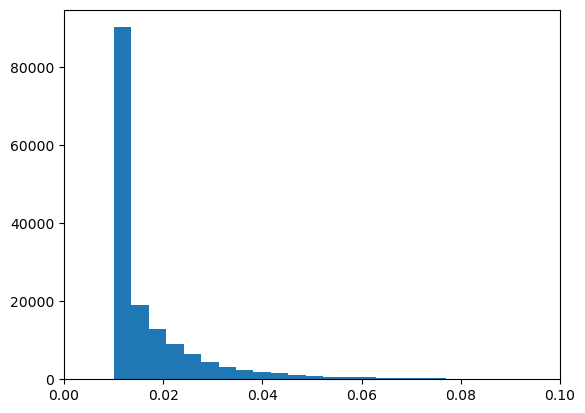

In [12]:
plt.hist(scales.max(1), bins=100);
plt.xlim(0.0, 0.10)

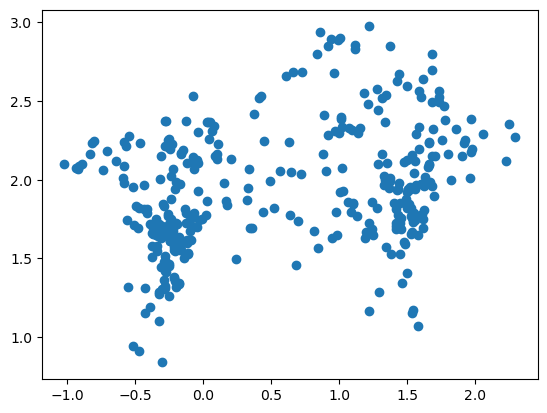

In [13]:
large = scales.max(1)> 0.1
plt.scatter(means[large, 0], means[large, 1])

In [25]:
def gaussian_in_aabb(aabb, strict=False):
    cond0 = ((aabb[0] < means) & (aabb[1] > means)) # In the box
    dist = np.stack((np.abs(means - aabb[0]), np.abs(means - aabb[1]))).min(0)
    dist[cond0] = 0
    # dist = np.matmul(rots, dist[..., None]).squeeze(-1) / scales
    dist = np.sqrt((dist ** 2).sum(1))
    # cond1 = dist <= (scales.max(1) * 3)
    cond1 = dist <= 0.04
    # return (cond0.all(1) | cond1) & constraint
    if strict:
        return (cond0.all(1) | cond1) & constraint
    else:
        return cond0.all(1) & constraint
    

def in_aabb(aabb, strict=False):
    # cond = (aabb[0] < means) & (aabb[1] > means)
    cond = gaussian_in_aabb(aabb, strict=strict)
    return cond

def get_count(aabb, strict=False):
    cond = gaussian_in_aabb(aabb, strict=strict)
    return cond.sum()

def split_aabb(aabb, axis=None, at=0.5):
    split = aabb[0] + (aabb[1] - aabb[0]) * at
    # print(split)
    if axis is None:
        return [aabb[0], split], [split, aabb[1]]
    aabb0 = [np.copy(aabb[0]), np.copy(aabb[1])]
    aabb1 = [np.copy(aabb[0]), np.copy(aabb[1])]
    aabb0[1][axis] = split[axis]
    aabb1[0][axis] = split[axis]
    return aabb0, aabb1

def get_split_costs(aabb, splits=[0.5], strict=False):
    costs = [[], [], []]
    for split in splits:
        for axis in range(3):
            aabb0, aabb1 = split_aabb(aabb, axis, split)
            (wa, ha, da) = aabb0[1] - aabb0[0]
            (wb, hb, db) = aabb1[1] - aabb1[0]
            # boxcosta = (abs(wa-ha)/(wa+ha) + abs(wa-da)/(wa+da) + abs(ha-da)/(ha+da)) / 3
            # boxcostb = (abs(wb-hb)/(wb+hb) + abs(wb-db)/(wb+db) + abs(hb-db)/(hb+db)) / 3
            boxcosta = ((wa-ha)**2/(wa*ha) + (wa-da)**2/(wa*da) + (ha-da)**2/(ha*da)) / 3
            boxcostb = ((wb-hb)**2/(wb*hb) + (wb-db)**2/(wb*db) + (hb-db)**2/(hb*db)) / 3
            costa = get_count(aabb0, strict=strict)
            costb = get_count(aabb1, strict=strict)
            costs[axis].append(abs(costa - costb) / (costa + costb) + 0.0 * (boxcosta + boxcostb) / 2)
    return np.array(costs)

In [15]:
splits = np.linspace(0.1, .9, 9)
# splits = [0.5]
costs = get_split_costs(aabb, splits=splits)
axis_split = np.argmin(costs.min(1))
split = splits[np.argmin(costs[axis_split])]
costs, axis_split, costs.min(1), splits, split

(array([[1.09253038, 0.8448679 , 0.38281131, 0.17901675, 0.11599617,
         0.04885812, 0.2897573 , 0.77977587, 1.09162756],
        [1.14278801, 0.91211872, 0.53549572, 0.20502517, 0.23209593,
         0.62890539, 0.90997516, 1.06044818, 1.17410695],
        [1.13936731, 0.78087572, 0.42693507, 0.21432088, 0.68585239,
         0.94671113, 1.02910311, 1.06460272, 1.1573347 ]]),
 0,
 array([0.04885812, 0.20502517, 0.21432088]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 0.6)

In [16]:
aabb0, aabb1 = split_aabb(aabb, axis_split, split)

In [17]:
get_count(aabb0), get_count(aabb1)

(75384, 81901)

In [18]:
a, b = in_aabb(aabb0), in_aabb(aabb1)

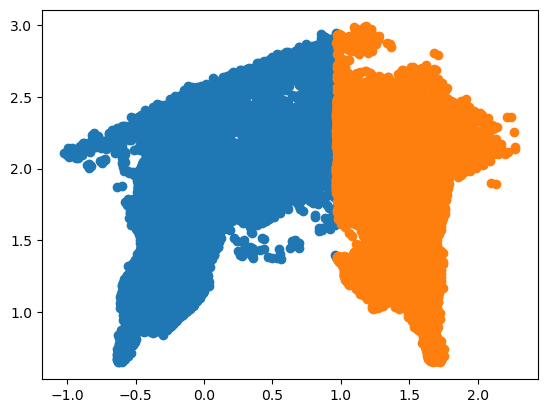

In [19]:
plt.scatter(means[a, 0], means[a, 1])
plt.scatter(means[b, 0], means[b, 1])

In [28]:
structure = dict()

# def stop(aabb):
#     c = get_count(aabb)
#     # print(c)
#     return c < 1000

def stop(aabb, aabb0, aabb1, strict=False):
    count, count0, count1 = get_count(aabb, strict=strict), get_count(aabb0, strict=strict), get_count(aabb1, strict=strict)
    return (max(count0, count1) >= (count - count / 10)) or count < 2500
    
    
# splits = np.linspace(0.1, .9, 9)
splits = [0.25, 0.5, 0.75]
# splits = [0.4, 0.5, 0.6]

strict = False
def get_structure(aabb, idx, depth):
    # print(idx)
    data = {
        "mins": aabb[0].tolist() + [False],
        "maxs": aabb[1].tolist(),
    }
    if get_count(aabb) == 0:
        return idx - 1
    # if stop(aabb):
    #     if get_count(aabb) == 0:
    #         return idx - 1
    #     children = np.where(in_aabb(aabb))[0]
    #     data["mins"][-1] = True
    #     data["child_indices"] = children.tolist()
    #     structure[idx] = data
    #     return idx
    
    # costs = get_split_costs(aabb)
    # axis_split = np.argmin(costs)
    # aabb0, aabb1 = split_aabb(aabb, axis_split)

    costs = get_split_costs(aabb, splits=splits, strict=False)
    axis_split = np.argmin(costs.min(1))
    split = splits[np.argmin(costs[axis_split])]
    aabb0, aabb1 = split_aabb(aabb, axis_split, split)
    # print(costs, axis_split)

    if stop(aabb, aabb0, aabb1):
        children = np.where(in_aabb(aabb, strict=strict))[0]
        print(children.size)
        print(depth)
        print(aabb[1] - aabb[0])
        data["mins"][-1] = True
        data["child_indices"] = children.tolist()
        structure[idx] = data
        return idx
    
    idxa = idx + 1
    idx0 = get_structure(aabb0, idxa, depth+1)
    idxb = idx0 + 1
    idx1 = get_structure(aabb1, idxb, depth+1)
    # print(idxa, idx0)

    children = []
    if idxa <= idx0:
        children.append(idxa)
    if idxb <= idx1:
        children.append(idxb)
    data["child_indices"] = children
    # if len(children) == 1:
    #     print("then here", idx)
    #     child = children[0]
    #     print(child)
    #     data["child_indices"] = structure[child]["child_indices"]
    #     data["mins"][-1] = structure[child]["mins"][-1]
    #     del structure[child]
    
    structure[idx] = data
    return idx1

aabb = [means[constraint].min(0), means[constraint].max(0)]
boxsize = aabb[1] - aabb[0]
aabb = [aabb[0] - boxsize * 0.1, aabb[1] + boxsize * 0.1]

get_structure(aabb, 0, 0)
# structure[0]["mins"] = aabb_root[0].tolist() + [False]
# structure[0]["maxs"] = aabb_root[1].tolist()
structure = OrderedDict(sorted(structure.items()))
len(structure)

1129
7
[0.99449487 0.4513459  3.05055056]
1525
7
[0.99449487 0.15044863 3.05055056]
1913
6
[0.99449487 0.20059818 3.05055056]
2431
7
[0.12431186 0.80239271 3.05055056]
2432
7
[0.12431186 0.80239271 3.05055056]
2218
6
[0.74587115 0.80239271 3.05055056]
1963
7
[1.98898973 0.03343303 3.05055056]
1813
7
[1.98898973 0.03343303 3.05055056]
1911
7
[1.98898973 0.03343303 3.05055056]
1342
8
[1.98898973 0.01671651 3.05055056]
1212
8
[1.98898973 0.01671651 3.05055056]
1745
7
[1.98898973 0.13373212 1.14395646]
2294
7
[1.98898973 0.13373212 0.38131882]
1882
7
[1.98898973 0.06686606 1.52527528]
1339
7
[1.98898973 0.06686606 1.52527528]
1988
6
[1.98898973 0.08915475 1.52527528]
2476
6
[1.98898973 0.08915475 1.52527528]
2471
6
[0.99449487 0.17830949 1.52527528]
2425
6
[0.99449487 0.17830949 1.52527528]
1399
6
[1.98898973 0.08915475 1.52527528]
1696
6
[1.98898973 0.08915475 1.52527528]
1851
6
[1.98898973 0.08915475 1.52527528]
1232
7
[1.98898973 0.04457737 1.52527528]
1736
7
[1.98898973 0.04457737 1.52

171

In [29]:
aabb

[array([-1.35294785,  0.40703977,  2.07238109]),
 array([2.62503161, 3.25999163, 5.12293165])]

In [30]:
points = set()
for k, v in structure.items():
    if v["mins"][-1]:
        points |= set(v["child_indices"])
len(points)

157291

In [31]:
# with open("resources/objects/private/nisse_15k_spatial_bvh_v1.json", "w") as f:
#     json.dump(structure, f, indent=6)
# with open("resources/objects/private/nisse_full_spatial_bvh.json", "w") as f:
#     json.dump(structure, f, indent=6)
with open("resources/objects/private/nisse_full_both_spatial_bvh.json", "w") as f:
    json.dump(structure, f, indent=6)

In [24]:
np.cross(np.array((0, 2, 0)), np.array((-0.15, -1.5, -1)))

array([-2. ,  0. ,  0.3])